In [26]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications import InceptionV3

In [27]:
def preprocess(image, label):
    image = tf.image.resize(image, [75, 75])  # Resize to match InceptionV3 input size
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0,1]
    return image, label

In [28]:
def augment(image, label):
    image = tf.image.resize(image, [75, 75])
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.1) # Adjust brightness by up to 10%
    image = tf.image.random_contrast(image, lower=0.95, upper=1.05) # Adjust contrast between 90% and 110%
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

In [29]:
(ds_train, ds_validation), ds_info = tfds.load(
    'malaria',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    with_info=True,
)

In [30]:
train_ds = ds_train.map(augment).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = ds_validation.map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)

In [38]:
base_model = InceptionV3(input_shape=(75, 75, 3), include_top=False, weights='imagenet')

# Freeze the base model
base_model.trainable = True

In [39]:
model = Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    Dense(1024, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # Assuming binary classification
])

In [40]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

history = model.fit(train_ds,
                    epochs=5,
                    validation_data=val_ds)


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 1, 1, 2048)        21802784  
                                                                 
 global_average_pooling2d_4  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_8 (Dense)             (None, 1024)              2098176   
                                                                 
 dropout_4 (Dropout)         (None, 1024)              0         
                                                                 
 dense_9 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 23901985 (91.18 MB)
Trainable params: 23867553 (91.05 MB)
Non-trainable params: 34432 (134.50 KB)
________

In [41]:
def plot_learningCurve(history, epoch):
    epoch_range = range(1, epoch + 1)
    plt.plot(epoch_range, history.history['accuracy'])
    plt.plot(epoch_range, history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

    plt.plot(epoch_range, history.history['loss'])
    plt.plot(epoch_range, history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

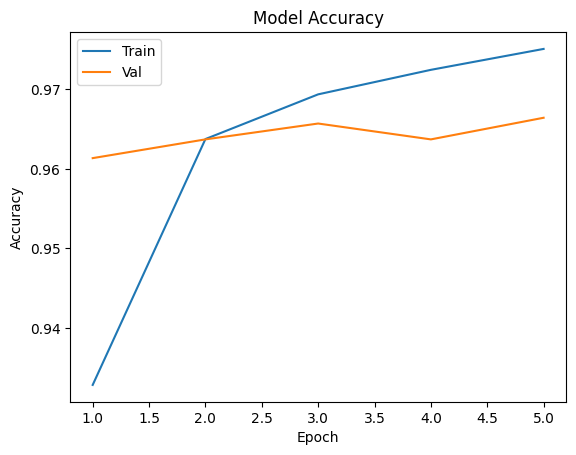

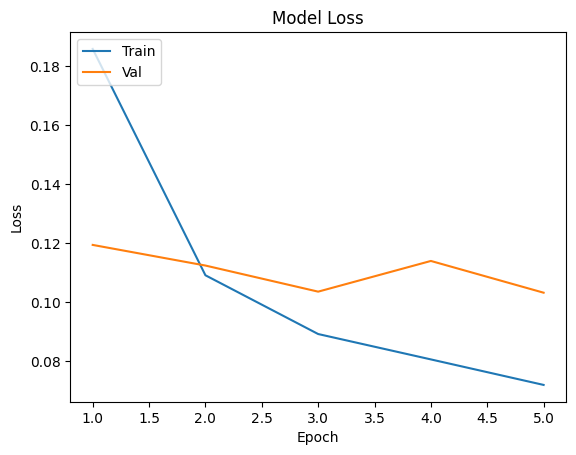

In [42]:
plot_learningCurve(history, 5)